<a href="https://colab.research.google.com/github/balados85/ML_Labs/blob/main/Assignment_Computer_Vision_mandatory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 1 - Computer vision: Based on Keras**

##**Loading FashionMNIST data**

In [115]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.backend import clear_session
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
def load_data():
  (training_set, test_set), ds_info = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    batch_size = -1,
    with_info=True,)
  
  ##Split training data into training and validation and scaling the data
  training_data, validation_data, training_labels, validation_labels = train_test_split(training_set[0].numpy(), training_set[1].numpy(),train_size=0.7, test_size = 0.3, random_state=100)
  training_data  = training_data/255.0        ## rescaling the data
  validation_data = validation_data/255.0     ## rescaling the data

  test_data = test_set[0].numpy()
  test_labels = test_set[1].numpy()
  test_data = test_data / 255.0

  ##Plot a sample of the data
  fig = plt.figure(figsize=(8,8))
  for i in range(1,10):
    fig.add_subplot(3,3,i)
    plt.imshow(training_data[i].squeeze())
    plt.grid(False)

  return training_data, training_labels, validation_data, validation_labels, test_data, test_labels

##**Building Multi Layer Perceptron**

In [81]:
def mlp_model():
  input_shape = (28,28)
  layers = [512, 320, 128]
  output_features = 10

  model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(input_shape)),
        tf.keras.layers.Dense(layers[0], activation = "relu"),
        tf.keras.layers.Dense(layers[1], activation="relu"),
        tf.keras.layers.Dense(layers[2], activation="relu"),
        tf.keras.layers.Dense(output_features, activation="softmax")                 
  ])
  model.compile(optimizer = "adam", loss = tf.losses.sparse_categorical_crossentropy, metrics = ['accuracy'])
  return model

##**Model evaluation**

In [82]:
def evaluate_model(model, train_data, train_label, val_data, val_labels, test_data, test_label):
  #model = mlp_model()
  hist = model.fit(x = train_data, y = train_label, batch_size = 32, epochs = 25, verbose = 1, validation_data = (val_data, val_labels))
  _, score_acc = model.evaluate(test_data, test_label)
  pred = model.predict(x = test_data, batch_size=32)
  y_pred = y_pred = np.argmax(pred, axis=1)
  return score_acc,hist

In [83]:
def plot_training(history):
    fig, axs = plt.subplots(1,2,figsize=(16,5)) 
    axs[0].plot(history.history['accuracy'], color = 'blue') 
    axs[0].plot(history.history['val_accuracy'], color = 'red') 
    axs[0].set_title('Model Accuracy') 
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch') 
    axs[0].legend(['train', 'validate'], loc='upper left') 
    
    axs[1].plot(history.history['loss'], color = 'blue') 
    axs[1].plot(history.history['val_loss'], color = 'red') 
    axs[1].set_title('Model Loss') 
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch') 
    axs[1].legend(['train', 'validate'], loc='upper right') 
    plt.show()
#plot_training(hist)

##**Run putting it all together**

In [84]:
def all_together():
  train_data, train_label, val_data, val_labels, test_data, test_label = load_data()
  model = mlp_model()
  score, history = evaluate_model(model, train_data, train_label, val_data, val_labels, test_data, test_label)
  plot_training(history)
  print('> %.3f' % (score*100.0))

#all_together()

##**Build Convultional network**

In [85]:
def conv_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), input_shape = (28, 28, 1), padding='valid'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(2,2))

  model.add(Conv2D(32, (3, 3), padding='valid'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3), padding='valid'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10))
  model.add(Activation('softmax'))

  model.compile(optimizer = "adam", loss = tf.losses.sparse_categorical_crossentropy, metrics = ['accuracy'])
  return model

In [86]:
def all_together():
  train_data, train_label, val_data, val_labels, test_data, test_label = load_data()
  model = conv_model()
  score, history = evaluate_model(model, train_data, train_label, val_data, val_labels, test_data, test_label)
  plot_training(history)
  print('> %.3f' % (score * 100.0))

#all_together()

#**Fine-tune pretrained models**

##**Reconstructing some layers in the Conv net**

In [87]:
clear_session()
model = conv_model()
print(model.summary())
transfer_layer = model.get_layer('max_pooling2d_2')
conv_model = models.Model(inputs=model.input,outputs=transfer_layer.output)
reconstructed_model = Sequential()
reconstructed_model.add(conv_model)
reconstructed_model.add(Flatten())
reconstructed_model.add(Dense(1024, activation='relu'))
reconstructed_model.add(Dropout(0.5))
reconstructed_model.add(Dense(10, activation='softmax'))

reconstructed_model.compile(optimizer = "adam", loss = tf.losses.sparse_categorical_crossentropy, metrics = ['accuracy'])
print(reconstructed_model.summary())

def all_together():
  train_data, train_label, val_data, val_labels, test_data, test_label = load_data()
  score, history = evaluate_model(reconstructed_model, train_data, train_label, val_data, val_labels, test_data, test_label)
  plot_training(history)
  print('> %.3f' % (score * 100.0))

#all_together()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          1

##**Freezing layers**

In [88]:
def print_layer_trainable():
    for layer in model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [89]:
print_layer_trainable()

True:	conv2d
True:	activation
True:	max_pooling2d
True:	conv2d_1
True:	activation_1
True:	max_pooling2d_1
True:	conv2d_2
True:	activation_2
True:	max_pooling2d_2
True:	flatten
True:	dense
True:	activation_3
True:	dropout
True:	dense_1
True:	activation_4


In [90]:
model.get_layer('conv2d_2').trainable = False
model.get_layer('activation_2').trainable = False
model.get_layer('max_pooling2d_2').trainable = False

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          1

In [91]:
print_layer_trainable()

True:	conv2d
True:	activation
True:	max_pooling2d
True:	conv2d_1
True:	activation_1
True:	max_pooling2d_1
False:	conv2d_2
False:	activation_2
False:	max_pooling2d_2
True:	flatten
True:	dense
True:	activation_3
True:	dropout
True:	dense_1
True:	activation_4


In [92]:
def all_together():
  train_data, train_label, val_data, val_labels, test_data, test_label = load_data()
  score, history = evaluate_model(model, train_data, train_label, val_data, val_labels, test_data, test_label)
  plot_training(history)
  print('> %.3f' % (score * 100.0))

Epoch 1/25
1313/1313 [==============================] - 31s 23ms/step - loss: 0.8184 - accuracy: 0.7026 - val_loss: 0.5334 - val_accuracy: 0.8024
Epoch 2/25
1313/1313 [==============================] - 29s 22ms/step - loss: 0.5575 - accuracy: 0.8014 - val_loss: 0.4633 - val_accuracy: 0.8324
Epoch 3/25
1313/1313 [==============================] - 29s 22ms/step - loss: 0.4926 - accuracy: 0.8255 - val_loss: 0.4146 - val_accuracy: 0.8479
Epoch 4/25
1313/1313 [==============================] - 29s 22ms/step - loss: 0.4446 - accuracy: 0.8404 - val_loss: 0.3950 - val_accuracy: 0.8566
Epoch 5/25
1313/1313 [==============================] - 29s 22ms/step - loss: 0.4097 - accuracy: 0.8536 - val_loss: 0.3717 - val_accuracy: 0.8612
Epoch 6/25
1313/1313 [==============================] - 29s 22ms/step - loss: 0.3830 - accuracy: 0.8620 - val_loss: 0.3604 - val_accuracy: 0.8698
Epoch 7/25
1313/1313 [==============================] - 28s 22ms/step - loss: 0.3635 - accuracy: 0.8691 - val_loss: 0.3601 -

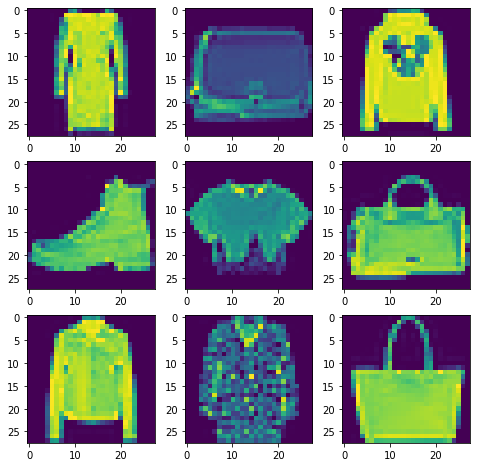

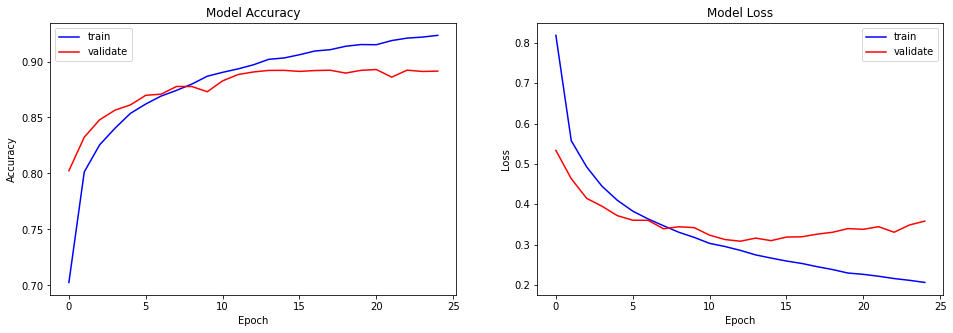

> 88.420


In [93]:
#all_together()

#**Augmenting the Data**

In [129]:
def data_augmentation():
  train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2, 
    shear_range = 0.2,
    zoom_range = 0.2, 
    horizontal_flip = True,
    fill_mode = 'nearest'
  )

  test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(
        'drive/MyDrive/data/hymenoptera_data/train',  
        target_size=(224, 224), 
        batch_size=16,
        class_mode='binary')  

  validation_generator = test_datagen.flow_from_directory(
        'drive/MyDrive/data/hymenoptera_data/val',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary')
  return train_generator, validation_generator

In [137]:
def binary_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape = (224,224, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
  return model

In [138]:
model_binary = binary_model() 
train_generator, validation_generator = data_augmentation()

history = model_binary.fit(x=train_generator,
                        epochs=25,
                        steps_per_epoch=16,
                        validation_data=validation_generator)

Found 243 images belonging to 2 classes.
Found 153 images belonging to 2 classes.
Epoch 1/25
16/16 [==============================] - 135s 9s/step - loss: 78.4450 - accuracy: 0.5309 - val_loss: 0.6928 - val_accuracy: 0.5490
Epoch 2/25
16/16 [==============================] - 15s 958ms/step - loss: 0.8223 - accuracy: 0.6173 - val_loss: 0.6928 - val_accuracy: 0.5425
Epoch 3/25
16/16 [==============================] - 15s 952ms/step - loss: 0.8260 - accuracy: 0.5514 - val_loss: 0.6935 - val_accuracy: 0.4641
Epoch 4/25
16/16 [==============================] - 15s 948ms/step - loss: 0.7806 - accuracy: 0.5679 - val_loss: 0.6948 - val_accuracy: 0.4575
Epoch 5/25
16/16 [==============================] - 15s 952ms/step - loss: 0.7691 - accuracy: 0.5309 - val_loss: 0.6955 - val_accuracy: 0.4575
Epoch 6/25
16/16 [==============================] - 15s 957ms/step - loss: 0.9495 - accuracy: 0.5473 - val_loss: 0.6952 - val_accuracy: 0.4575
Epoch 7/25
16/16 [==============================] - 15s 952ms

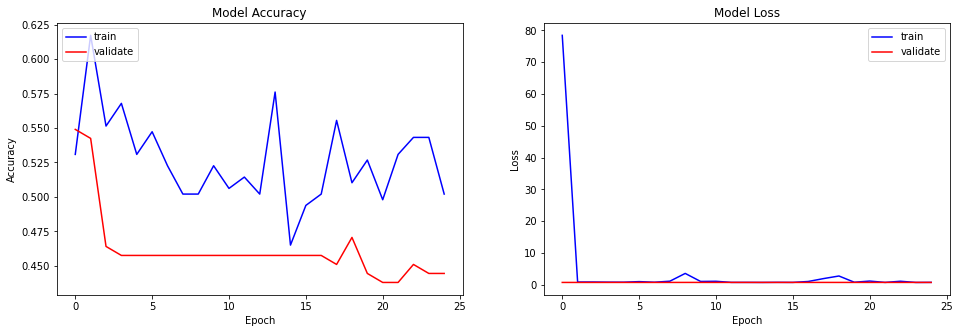

In [139]:
 plot_training(history)